In [1]:
import torch

In [2]:
# Dataset : stores samples and labels
# Dataloader : Provides way of easy access to dataset by wrapping a iterable
# around the dataset

In [2]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor

In [7]:
training_data = datasets.FashionMNIST(root="data", train=True, download=True, transform=ToTensor())
testing_data = datasets.FashionMNIST(root="data", train=False, download=True, transform=ToTensor())

0


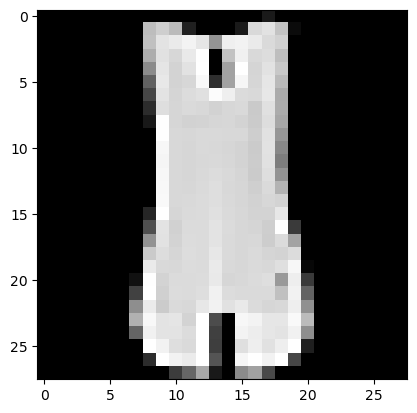

In [10]:
img, label = training_data[4]
plt.imshow(img.squeeze(), cmap='gray')
print(label)

# Creating a Custom dataset for the low dose CT dataset

In [12]:
import os
import pydicom

dataset_path = '../../../../../../Users/Tarun/Desktop/Files/College/Final-Year-Project/Dataset/LowDoseCTGrandChallenge/'

In [50]:
import numpy as np

def load_scan(path):
    # referred from https://www.kaggle.com/gzuidhof/full-preprocessing-tutorial
    slices = [pydicom.read_file(path)]
    return slices


def get_pixels_hu(slices):
    # referred from https://www.kaggle.com/gzuidhof/full-preprocessing-tutorial
    image = np.stack([s.pixel_array for s in slices])
    image = image.astype(np.int16)
    image[image == -2000] = 0
    for slice_number in range(len(slices)):
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
        image[slice_number] += np.int16(intercept)
    return np.int16(image)

def read_image(image_path):
    full_pixels = get_pixels_hu(load_scan(image_path))
    
    MIN_B= -1024.0
    MAX_B= 3072.0
    data = (full_pixels - MIN_B) / (MAX_B - MIN_B)
    
    return np.squeeze(np.expand_dims(data, axis=-1), axis=0)

def load_image_paths(low_dose_ct_training_dataset_dir, load_limited_images, num_images_to_load):
    noisy_image_paths = []
    for root, folder_name, file_names in os.walk(low_dose_ct_training_dataset_dir):
        for file_name in file_names:
            if "QD" in file_name:
                file_path = os.path.join(root, file_name)
                noisy_image_paths.append(file_path)

    clean_image_paths = []
    for root, folder_name, file_names in os.walk(low_dose_ct_training_dataset_dir):
        for file_name in file_names:
            if "FD" in file_name:   
                file_path = os.path.join(root, file_name)
                clean_image_paths.append(file_path)

    noisy_image_paths.sort()
    clean_image_paths.sort()

    if load_limited_images:
        noisy_image_paths = noisy_image_paths[:num_images_to_load]
        clean_image_paths = clean_image_paths[:num_images_to_load]
    
    return noisy_image_paths, clean_image_paths

In [51]:
class LDCTDataset(Dataset):
    def __init__(self, dataset_path, load_limited_images=True, num_images_to_load=30):
        self.clean_image_paths, self.noisy_image_paths  = load_image_paths(dataset_path, load_limited_images, num_images_to_load)

    def __len__(self):
        return len(self.clean_image_paths)
    
    def __getitem__(self, idx):
        clean_image_path = self.clean_image_paths[idx]
        noisy_image_path = self.noisy_image_paths[idx]
        
        clean_image = read_image(clean_image_path)
        noisy_image = read_image(noisy_image_path)
        
        return clean_image, noisy_image
        
d = LDCTDataset(dataset_path)

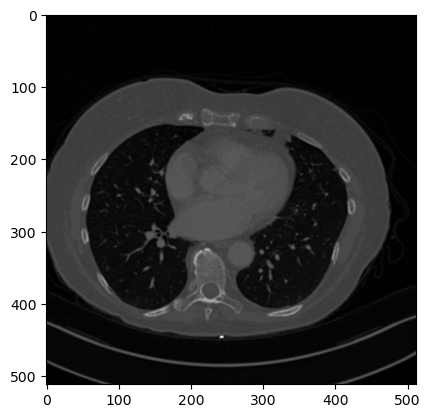

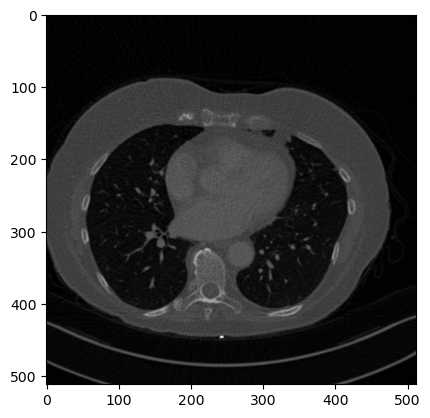

In [64]:
from torch.utils.data import DataLoader

# Batching + shuffling done by dataloader
training_dl = DataLoader(d, batch_size=64, shuffle=False)

clean, noisy = next(iter(training_dl))
plt.imshow(noisy[0], cmap='gray')
plt.show()
plt.imshow(clean[0], cmap='gray')